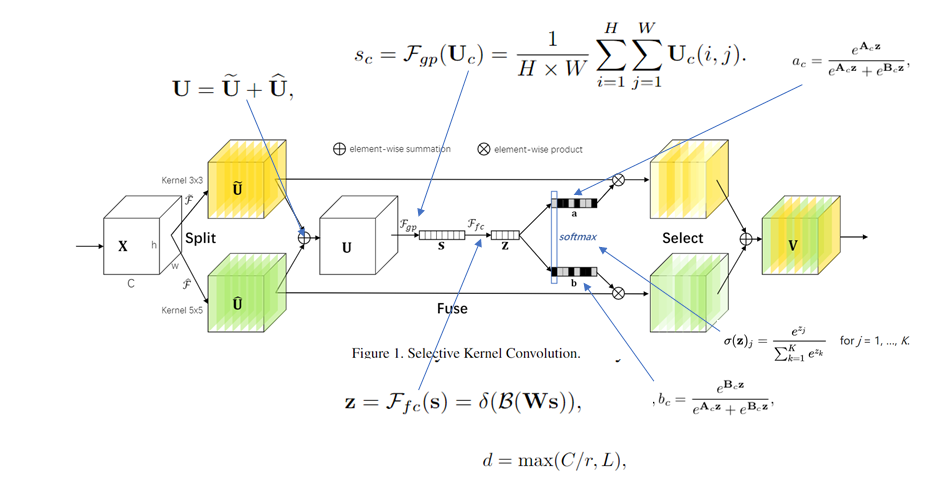

## SKconv

In [2]:
import torch
from torch import nn

#from thop import profile
#from thop import clever_format

class SKConv(nn.Module):
    def __init__(self, features, M=2, G=32, r=16, stride=1 ,L=32):
        """ Constructor
        Args:
            features: input channel dimensionality.
            M: the number of branchs.
            G: num of convolution groups.
            r: the ratio for compute d, the length of z.
            stride: stride, default 1.
            L: the minimum dim of the vector z in paper, default 32.
        """
        super(SKConv, self).__init__()
        d = max(int(features/r), L)
        self.M = M
        self.features = features
        self.convs = nn.ModuleList([])
        # M 使用几个卷积核去卷积
        for i in range(M):
            self.convs.append(nn.Sequential(
                nn.Conv2d(features, features, kernel_size=3, stride=stride, padding=1+i, dilation=1+i, groups=G, bias=False),
                nn.BatchNorm2d(features),
                nn.ReLU(inplace=True)
            ))
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(nn.Conv2d(features, d, kernel_size=1, stride=1, bias=False),
                                nn.BatchNorm2d(d),
                                nn.ReLU(inplace=True))
        self.fcs = nn.ModuleList([])
        # 每个卷积核，卷积后结果都需要全连接
        for i in range(M):
            self.fcs.append(
                 nn.Conv2d(d, features, kernel_size=1, stride=1)
            )
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        batch_size = x.shape[0]
        
        feats = [conv(x) for conv in self.convs]
        #进行拼接
        feats = torch.cat(feats, dim=1)
        feats = feats.view(batch_size, self.M, self.features, feats.shape[2], feats.shape[3])
        #U
        feats_U = torch.sum(feats, dim=1)
        #sc
        feats_S = self.gap(feats_U)
        #z
        feats_Z = self.fc(feats_S)

        #attention
        attention_vectors = [fc(feats_Z) for fc in self.fcs]
        attention_vectors = torch.cat(attention_vectors, dim=1)
        attention_vectors = attention_vectors.view(batch_size, self.M, self.features, 1, 1)
        #attention 的权重
        attention_vectors = self.softmax(attention_vectors)
        
        feats_V = torch.sum(feats*attention_vectors, dim=1)
        
        return feats_V

## SKunit

In [3]:
class SKUnit(nn.Module):
    def __init__(self, in_features, mid_features, out_features, M=2, G=32, r=16, stride=1, L=32):
        """ Constructor
        Args:
            in_features: input channel dimensionality.
            out_features: output channel dimensionality.
            M: the number of branchs.
            G: num of convolution groups.
            r: the ratio for compute d, the length of z.
            mid_features: the channle dim of the middle conv with stride not 1, default out_features/2.
            stride: stride.
            L: the minimum dim of the vector z in paper.
        """
        super(SKUnit, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features, mid_features, 1, stride=1, bias=False),
            nn.BatchNorm2d(mid_features),
            nn.ReLU(inplace=True)
            )
        
        self.conv2_sk = SKConv(mid_features, M=M, G=G, r=r, stride=stride, L=L)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(mid_features, out_features, 1, stride=1, bias=False),
            nn.BatchNorm2d(out_features)
            )
        

        if in_features == out_features: # when dim not change, input_features could be added diectly to out
            self.shortcut = nn.Sequential()
        else: # when dim not change, input_features should also change dim to be added to out
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_features, out_features, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_features)
            )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.conv2_sk(out)
        out = self.conv3(out)
        
        return self.relu(out + self.shortcut(residual))

## SKnet

In [4]:
class SKNet(nn.Module):
    def __init__(self, class_num, nums_block_list = [3, 4, 6, 3], strides_list = [1, 2, 2, 2]):
        super(SKNet, self).__init__()
        self.basic_conv = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        
        self.maxpool = nn.MaxPool2d(3,2,1)
        
        self.stage_1 = self._make_layer(64, 128, 256, nums_block=nums_block_list[0], stride=strides_list[0])
        self.stage_2 = self._make_layer(256, 256, 512, nums_block=nums_block_list[1], stride=strides_list[1])
        self.stage_3 = self._make_layer(512, 512, 1024, nums_block=nums_block_list[2], stride=strides_list[2])
        self.stage_4 = self._make_layer(1024, 1024, 2048, nums_block=nums_block_list[3], stride=strides_list[3])
     
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(2048, class_num)
        
    def _make_layer(self, in_feats, mid_feats, out_feats, nums_block, stride=1):
        layers=[SKUnit(in_feats, mid_feats, out_feats, stride=stride)]
        for _ in range(1,nums_block):
            layers.append(SKUnit(out_feats, mid_feats, out_feats))
        return nn.Sequential(*layers)

    def forward(self, x):
        fea = self.basic_conv(x)
        fea = self.maxpool(fea)
        fea = self.stage_1(fea)
        fea = self.stage_2(fea)
        fea = self.stage_3(fea)
        fea = self.stage_4(fea)
        fea = self.gap(fea)
        fea = torch.squeeze(fea)
        fea = self.classifier(fea)
        return fea
    
def SKNet26(nums_class=100):
    return SKNet(nums_class, [1, 1, 2, 1])
def SKNet50(nums_class=100):
    return SKNet(nums_class, [3, 4, 6, 3])
def SKNet101(nums_class=100):
    return SKNet(nums_class, [3, 4, 23, 3])

## test
#x = torch.rand(8, 3, 224, 224)
net = SKNet26()
#out = model(x)
#print('out shape : {}'.format(out.shape))
#如果有gpu就使用gpu，否则使用cpu
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
net = net.to(device)
device

device(type='cuda')

## Load data

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
#加载数据集
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
])

train_dataset = torchvision.datasets.cifar.CIFAR100(root='./data/cifar100', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.cifar.CIFAR100(root='./data/cifar100', train=False, transform=transform_test, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## train

In [6]:
#超参数设置
epochs = 30
BATCH_SIZE = 128
LR = 0.01

#定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)

#动态调整学习率
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 训练网络
def train(epoch, log_interval=128):
    # Set model to training model
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)
        
        # Zero gradient buffers
        optimizer.zero_grad()
        # Pass data through the network
        output = net(data)
        # Calculate loss
        loss = criterion(output, target)
        # Backpropagate
        loss.backward()
        # Update weights
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.data.item()))
# 验证网络
def validate(loss_vector, accuracy_vector):
    net.eval()
    val_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = net(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data).cpu().sum()
    
    val_loss /= len(test_loader)
    loss_vector.append(val_loss)
    
    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.04f}%)\n'.format(val_loss, correct, len(test_loader.dataset), accuracy))

## main函数

Train Epoch: 1 [0/50000 (0%)]	Loss: 4.736253
Train Epoch: 1 [16384/50000 (33%)]	Loss: 3.785982
Train Epoch: 1 [32768/50000 (65%)]	Loss: 3.890283
Train Epoch: 1 [49152/50000 (98%)]	Loss: 3.401800

Validation set: Average loss: 3.4289, Accuracy: 1845/10000 (18.4500%)

SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.01
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)
Train Epoch: 2 [0/50000 (0%)]	Loss: 3.202366
Train Epoch: 2 [16384/50000 (33%)]	Loss: 3.500243
Train Epoch: 2 [32768/50000 (65%)]	Loss: 3.354596
Train Epoch: 2 [49152/50000 (98%)]	Loss: 3.163889

Validation set: Average loss: 3.0637, Accuracy: 2433/10000 (24.3300%)

SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.01
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)
Train Epoch: 3 [0/50000 (0%)]	Loss: 2.972501
Train Epoch: 3 [16384/50000 (33%)]	Loss: 2.850490
Train Epoch: 3 [32768/50000 (65%)]	Loss: 2.883779
Train Epoch: 3 [49152/50000 (98%)]	Loss: 

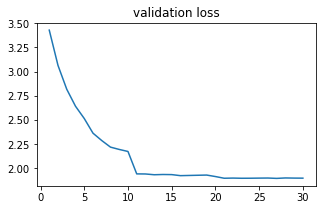

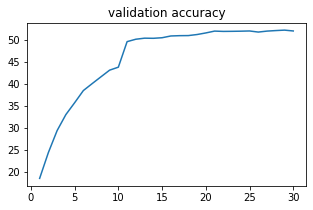

In [7]:
# 训练网络、打印训练过程
if __name__ == "__main__":
    lossv, accv = [], []
    for epoch in range(1, epochs + 1):
        train(epoch)
        validate(lossv, accv)
        scheduler.step()
        print(optimizer)

    print('Finished Training')

    # 绘制训练损失、精确度
    print("训练损失:{}\n训练精确度:{}%".format(lossv[-1], accv[-1].item()))
    plt.figure(figsize=(5,3))
    plt.plot(np.arange(1,epochs+1), lossv)
    plt.title('validation loss')
    plt.savefig('figs/SKnet20_loss.png')

    plt.figure(figsize=(5,3))
    plt.plot(np.arange(1,epochs+1), accv)
    plt.title('validation accuracy')
    plt.savefig('figs/SKnet20_accuracy.png')